# Imports

In [39]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import re
import matplotlib.pyplot as plt

# Load Data

In [40]:
sub_files = glob('../../../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [41]:
xdf_path = sub_files[1]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Stimuli_Markers',
 'Tobii',
 'OpenSignals',
 'EGI NetAmp 0',
 'Microphone']

# Stimulus

In [42]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,652877.853621,0.000000e+00
1,1729108775,psychopy_time_stamp,652877.853632,1.079973e-08
2,10,Onset_RestingState,652903.462754,2.560913e-02
3,1729108800,psychopy_time_stamp,652903.462766,2.560914e-02
4,11,Offset_RestingState,653203.463529,3.256099e-01
...,...,...,...,...
256,1729111346,psychopy_time_stamp,655451.996951,2.574143e+00
257,201,Offset_Experiment,655456.997079,2.579143e+00
258,1729111351,psychopy_time_stamp,655456.997089,2.579143e+00
259,4,Bx_input,655456.997128,2.579144e+00


# Eye Tracking Data

In [43]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time
0,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.459065,0.000000
1,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.467398,0.000008
2,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.475732,0.000017
3,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.484066,0.000025
4,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.492399,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137765,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.084729,2.779626
137766,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.093062,2.779634
137767,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.101396,2.779642
137768,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.109730,2.779651


In [57]:
#nsamp
int(ET['footer']['info']['sample_count'][0])


137769

In [58]:
et_df['lsl_time_stamp'].iloc[-1] - et_df['lsl_time_stamp'].iloc[0]

2779.6589983566664

In [55]:
# srate
ET['info']['effective_srate']


119.99583772142171

In [49]:
et_df['time'].iloc[-1]

2.7796589983566666

In [51]:
et_resting = get_event_data('RestingState', et_df, stim_df)
time = et_df['lsl_time_stamp'].iloc[-1] - et_df['lsl_time_stamp'].iloc[0]

nsamp = len(et_df)

nsamp/time

49.56363355413365

In [6]:
# get percent valid items from validity columns
val_cols = et_df.filter(like = 'validity').columns
val_df = pd.DataFrame(columns = ['variable', 'percent_valid'])
val_df['variable'] = val_cols

for i, var in enumerate(val_cols):
    val_df.loc[i, 'percent_valid'] = round(np.mean(et_df[var]), 4)

val_df

,variable,percent_valid
0,left_gaze_origin_validity,0.4191
1,right_gaze_origin_validity,0.4458
2,left_gaze_point_validity,0.4098
3,right_gaze_point_validity,0.4441
4,left_pupil_validity,0.4098
5,right_pupil_validity,0.4441


In [7]:
# percent valid for all data columns (excluding time + validity columns)

# remove columns w validity or time data 
time_cols = et_df.filter(like = 'time').columns
qc_cols = time_cols.append(val_cols)
et_data_cols = et_df.columns.drop(qc_cols)

# percent non-NaN for each variable
et_qc = pd.DataFrame(columns= ['variable', 'percent_valid'])
et_qc['variable'] = et_data_cols

for i, var in enumerate(et_data_cols):
    et_qc.loc[i, 'percent_valid'] = round((1 - et_df[var].isna().mean()), 4)

et_qc

,variable,percent_valid
0,left_gaze_origin_in_user_coordinate_system_0,0.4191
1,left_gaze_origin_in_user_coordinate_system_1,0.4191
2,left_gaze_origin_in_user_coordinate_system_2,0.4191
3,right_gaze_origin_in_user_coordinate_system_0,0.4458
4,right_gaze_origin_in_user_coordinate_system_1,0.4458
5,right_gaze_origin_in_user_coordinate_system_2,0.4458
6,left_gaze_origin_in_trackbox_coordinate_system_0,0.4191
7,left_gaze_origin_in_trackbox_coordinate_system_1,0.4191
8,left_gaze_origin_in_trackbox_coordinate_system_2,0.4191
9,right_gaze_origin_in_trackbox_coordinate_system_0,0.4458


## Comparing Percents between Validity, Coordinates, and Coordinate Systems

In [8]:
# compare NaN percentage in each measure with validity 

# for each row of val_df
flag = False
for row in range(len(val_df)):
    # assign percent_valid to a var 
    val_percent = val_df.loc[row, 'percent_valid']

    # get name of 'variable' without _validity 
    searchable = val_df.loc[row, 'variable']
    searchable = searchable.replace('_validity', '')

    # find corresponding variable in et_qc
    found = et_qc[et_qc['variable'].str.contains(searchable)]

    # Check if floats are close enough to each other
    delta = 0.0000001
    for i in found.index:
        etqc_percent = found.loc[i, 'percent_valid']
        etqc_variable = found.loc[i, 'variable']
        diff = etqc_percent - val_percent
        
        if abs(diff) > delta:
            print("ERROR: {} and {} were different by a difference of {}.".format(etqc_variable, searchable, diff))
            flag = True
if not flag:
    print("validity variables equal % of present data for each measure")



validity variables equal % of present data for each measure


In [9]:
# compare coordinates (0,1,2)
flag = False
for i in range(1, len(et_qc)):
    # get variables that end in numbers 
    root = re.sub(r"_\d+$", "", et_qc.loc[i, 'variable'])
    if root in et_qc.loc[i-1, 'variable']:
        current_percent = et_qc.loc[i, 'percent_valid']
        prev_percent = et_qc.loc[i-1, 'percent_valid']
        if current_percent != prev_percent:
            print("ERROR: {} does not equal {}!".format(et_qc.loc[i-1, 'variable'], et_qc.loc[i, 'variable']))
            flag = True
if not flag:
    print("all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter)")



all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter)


In [10]:
# compare coordinate systems 

flag = False
for i in range(1, len(et_qc)):
    root = et_qc.loc[i, 'variable'].split("_in")[0]
    root_percent = et_qc.loc[i, 'percent_valid']

    matching = et_qc[et_qc['variable'].str.contains(root)]

    for i in matching.index:
            matching_percent = matching.loc[i, 'percent_valid']
            matching_variable = matching.loc[i, 'variable']

            if root_percent != matching_percent:
                print("ERROR: {} and {} were different by a difference of {}.".format(matching_variable, root, (root_percent-matching_percent)))
                flag = True
   
if not flag:
    print("% NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point)")



% NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point)


## Compare valid data between left and right eyes

In [11]:
left = et_qc[et_qc.variable.str.startswith('left')]
right = et_qc[et_qc.variable.str.startswith('right')]

RL_val = pd.DataFrame(columns = ['eye','min', 'max', 'mean'])

for i, (df, RL) in enumerate([(left, 'left'), (right, 'right')]):
    min1 = min(df['percent_valid'])
    max1 = max(df['percent_valid'])
    mean1 = round(np.mean(df['percent_valid']), 4)
    RL_val.loc[i] = [RL, min1, max1, mean1]


RL_val

,eye,min,max,mean
0,left,0.4098,0.4191,0.4144
1,right,0.4441,0.4458,0.4450


In [12]:
# find diff between RL 
RL_val.loc[2] = ['diff', RL_val['min'].diff()[1], RL_val['max'].diff()[1], RL_val['mean'].diff()[1]]

# add blank row 
blank = pd.DataFrame([['', '', '', '']], columns = RL_val.columns)
RL_val = pd.concat([RL_val.iloc[:2], blank, RL_val.iloc[2:]])
RL_val.reset_index(drop=True, inplace=True)
RL_val


,eye,min,max,mean
0,left,0.4098,0.4191,0.4144
1,right,0.4441,0.4458,0.445
2,,,,
3,diff,0.0343,0.0267,0.0306


In [13]:
lmean = RL_val.loc[RL_val.eye =='left', 'mean'][0]
rmean = RL_val.loc[RL_val.eye =='right', 'mean'][1]
mean_diff = RL_val.loc[RL_val.eye =='diff', 'mean'][3]

print('mean validity for left eye is {:.2%}.\n\
mean validity for right eye is {:.2%}.\n\
the difference is {:.2%}.'.format(lmean, rmean, abs(mean_diff)))

mean validity for left eye is 41.44%.
mean validity for right eye is 44.50%.
the difference is 3.06%.


## Gaze Point Min + Max

In [14]:
minmax = {}
for eye, e in zip(['left', 'right'], ['l', 'r']):
    for disp in ['0', '1']:
        minmax[f'min_{e}{disp}'] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        minmax[f'max_{e}{disp}'] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        
        # globals()['min_'+e+disp] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        # globals()['max_'+e+disp] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)


In [15]:
print(f"Left eye: \n\
      Display area 0 min: {minmax['min_l0']:.4}, max: {minmax['max_l0']:.4}\n\
      Display area 1 min: {minmax['min_l1']:.4}, max: {minmax['max_l1']:.4}\n\
      \n\
Right eye: \n\
      Display area 0 min: {minmax['min_r0']:.4}, max: {minmax['max_r0']:.4}\n\
      Display area 1 min: {minmax['min_r1']:.4}, max: {minmax['max_r1']:.4}")

# left and right eye display area 0 min pretty different

Left eye: 
      Display area 0 min: -1.575, max: 3.499
      Display area 1 min: -0.73, max: 2.154
      
Right eye: 
      Display area 0 min: -2.383, max: 2.358
      Display area 1 min: -0.885, max: 2.102


In [16]:
left_display = pd.DataFrame(columns = ['display area', 'min', 'max'])
right_display = pd.DataFrame(columns = ['display area', 'min', 'max'])

left_display.loc[0] = ['0', minmax['min_l0'], minmax['max_l0']]
left_display.loc[1] = ['1', minmax['min_l1'], minmax['max_l1']]

right_display.loc[0] = ['0', minmax['min_r0'], minmax['max_r0']]
right_display.loc[1] = ['1', minmax['min_r1'], minmax['max_r1']]

display(left_display)
display(right_display)

,display area,min,max
0,0,-1.575,3.499
1,1,-0.730,2.154


,display area,min,max
0,0,-2.383,2.358
1,1,-0.885,2.102


In [17]:
print(f"The difference between left and right is: \n\
      display area 0 min: {minmax['min_l0']-minmax['min_r0']:.3}, max: {minmax['max_l0']-minmax['max_r0']:.3} \n\
      display area 1 min: {minmax['min_l1']-minmax['min_r1']:.3}, max: {minmax['max_l1']-minmax['max_r1']:.3}")

The difference between left and right is: 
      display area 0 min: 0.808, max: 1.14 
      display area 1 min: 0.155, max: 0.052


In [27]:
et_df.left_gaze_point_on_display_area_1[44]

-0.2515065

(-3.0, 3.0)

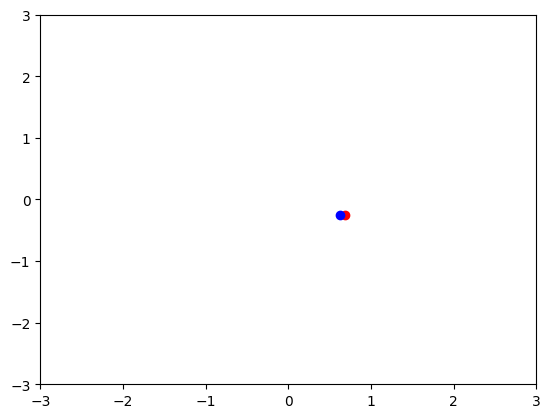

In [28]:
plt.scatter(et_df.left_gaze_point_on_display_area_0[44], et_df.left_gaze_point_on_display_area_1[44], color = 'red')
plt.scatter(et_df.right_gaze_point_on_display_area_0[44], et_df.right_gaze_point_on_display_area_1[44], color = 'blue')
plt.xlim([-3,3])
plt.ylim([-3,3])

In [33]:
~np.isnan(et_df.left_gaze_point_on_display_area_0)

0         False
1         False
2         False
3         False
4         False
          ...  
137765    False
137766    False
137767    False
137768    False
137769    False
Name: left_gaze_point_on_display_area_0, Length: 137770, dtype: bool

In [36]:
et_nums = et_df[~np.isnan(et_df.left_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.left_gaze_point_on_display_area_1) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_1)]

NameError: name 'ax' is not defined

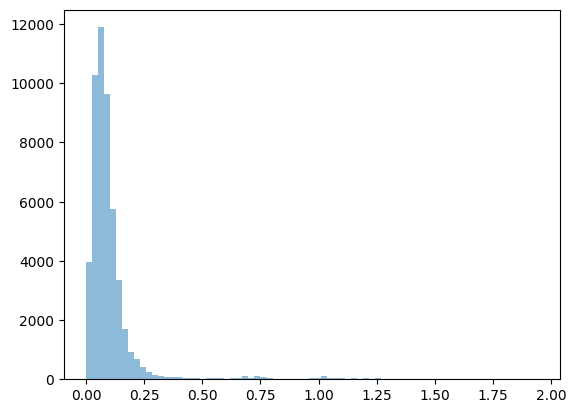

In [38]:
x1 = et_nums.right_gaze_point_on_display_area_0
x2 = et_nums.left_gaze_point_on_display_area_0
y1 = et_nums.right_gaze_point_on_display_area_1
y2 = et_nums.left_gaze_point_on_display_area_1
dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

plt.hist(dists, bins =75, alpha = 0.5)
ax.set_title(f'Distribution of Distances Between \nLeft and Right Gaze Points for Subject {sub_name}')
ax.set_xlabel('Distance between L + R Gaze Points')
ax.set_ylabel('Count')


## Compare R vs L validity across participants

In [23]:
def RL_percent(id):
    # load data
    num = [i for i, string in enumerate(sub_files) if id in string][0]
    xdf_path = sub_files[num]     
    data, header = pyxdf.load_xdf(xdf_path)
    streams_collected = [stream['info']['name'][0] for stream in data]

    # extract eye tracking data
    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)

    # get percent valid items from validity columns
    val_cols = et_df.filter(like = 'validity').columns
    val_df = pd.DataFrame(columns = ['variable', 'percent_valid'])
    val_df['variable'] = val_cols
    for i, var in enumerate(val_cols):
        val_df.loc[i, 'percent_valid'] = round(np.mean(et_df[var]), 4)

    # compare mean left and right validity
    left_df = val_df[val_df.variable.str.startswith('left')]
    right_df = val_df[val_df.variable.str.startswith('right')]   
    lmean = round(np.mean(left_df['percent_valid']), 4)
    rmean = round(np.mean(right_df['percent_valid']), 4)

    # format in a df for vibes 
    RL_val = pd.DataFrame(columns = ['eye', 'mean'])
    RL_val = RL_val.reindex([0,1]) # adds NaN rows w index 0 + 1
    RL_val.loc[[0, 1]] = [['left', lmean], ['right', rmean]]

    diff = rmean - lmean

    print('mean validity for left eye is {:.2%}.\n\
mean validity for right eye is {:.2%}.\n\
the difference is {:.2%}.'.format(lmean, rmean, abs(diff)))
    
    if diff > 0:
        print("right eye has higher validity than left.")
    else:
        print("left eye has higher validity than right.")

    return RL_val


In [24]:
RL_percent("P5318014")

KeyboardInterrupt: 

In [21]:
RL_percent("5182010")

mean validity for left eye is 41.29%.
mean validity for right eye is 44.47%.
the difference is 3.18%.
right eye has higher validity than left.


,eye,mean
0,left,0.4129
1,right,0.4447


In [22]:
RL_percent("P5548165")

mean validity for left eye is 83.59%.
mean validity for right eye is 80.36%.
the difference is 3.23%.
left eye has higher validity than right.


,eye,mean
0,left,0.8359
1,right,0.8036


## Compare display area min + max across participants

In [23]:
def display_minmax(id):
    # load data
    num = [i for i, string in enumerate(sub_files) if id in string][0]
    xdf_path = sub_files[num]     
    data, header = pyxdf.load_xdf(xdf_path)
    streams_collected = [stream['info']['name'][0] for stream in data]

    # extract eye tracking data
    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)

    # get 
    minmax = {}
    for eye, e in zip(['left', 'right'], ['l', 'r']):
        for disp in ['0', '1']:
            minmax[f'min_{e}{disp}'] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
            minmax[f'max_{e}{disp}'] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)

    left_display = pd.DataFrame(columns = ['display area', 'min', 'max'])
    right_display = pd.DataFrame(columns = ['display area', 'min', 'max'])

    left_display.loc[0] = ['0', minmax['min_l0'], minmax['max_l0']]
    left_display.loc[1] = ['1', minmax['min_l1'], minmax['max_l1']]
    right_display.loc[0] = ['0', minmax['min_r0'], minmax['max_r0']]
    right_display.loc[1] = ['1', minmax['min_r1'], minmax['max_r1']]

    print("left:")
    display(left_display)
    print("\nright:")
    display(right_display)

    print(f"The difference between left and right is: \n\
      display area 0 min: {minmax['min_l0']-minmax['min_r0']:.3}, max: {minmax['max_l0']-minmax['max_r0']:.3} \n\
      display area 1 min: {minmax['min_l1']-minmax['min_r1']:.3}, max: {minmax['max_l1']-minmax['max_r1']:.3}")





In [24]:
display_minmax("P5318014")

left:


,display area,min,max
0,0,-1.154,2.133
1,1,-0.675,1.785



right:


,display area,min,max
0,0,-1.615,2.027
1,1,-0.663,1.760


The difference between left and right is: 
      display area 0 min: 0.461, max: 0.106 
      display area 1 min: -0.012, max: 0.025


In [25]:
display_minmax("P5548165")

left:


,display area,min,max
0,0,-1.137,2.029
1,1,-0.786,1.473



right:


,display area,min,max
0,0,-1.338,1.621
1,1,-0.678,1.445


The difference between left and right is: 
      display area 0 min: 0.201, max: 0.408 
      display area 1 min: -0.108, max: 0.028


In [26]:
display_minmax("5182010")

left:


,display area,min,max
0,0,-1.575,3.499
1,1,-0.730,2.154



right:


,display area,min,max
0,0,-2.383,2.358
1,1,-0.885,2.102


The difference between left and right is: 
      display area 0 min: 0.808, max: 1.14 
      display area 1 min: 0.155, max: 0.052


## Visualizing NaNs

In [27]:
vis_df = et_df[['left_pupil_validity', 'right_pupil_validity']]
vis_df

,left_pupil_validity,right_pupil_validity
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
137765,0.0,0.0
137766,0.0,0.0
137767,0.0,0.0
137768,0.0,0.0


In [28]:
# plt.figure(figsize=(8, 6))

# # Iterate through the DataFrame and plot red or green dots
# for i, column in enumerate(vis_df):
#     for j in range(len(vis_df)):
#         if vis_df[column].iloc[j] == 1:
#             plt.scatter(i, j, color='green', label='1' if i == 0 and j == 0 else "", s=100)
#         elif vis_df[column].iloc[j] == 0:
#             plt.scatter(i, j, color='red', label='0' if i == 0 and j == 0 else "", s=100)

# plt.show()

